In [ ]:
def get_tree_percent(x):
    return x['geometry_tree'].intersection(x['geometry']).area/x['geometry'].area
#tract_taz['tract_pct'] = tract_taz[['geometry','geometry_taz']].apply(get_percent, axis = 1)


In [ ]:
def ix2xy(r,c,gt):
    '''Gets x,y from row and column'''
    x = gt[0] + r * gt[1]
    y = gt[3] + c * gt[5]
    return(x,y)

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import os
import gdal
import rasterio
import fiona
import rasterio.mask
from rastertodataframe import raster_to_dataframe
import itertools

## Read in Image Data

In [12]:
boundaryDir = r'data\boundaries'
treeDir = r'data\trees'
img_list = ['62451925.tif','62451930.tif','62451935.tif','62501920.tif','62501925.tif','62501930.tif']

In [4]:
delmar = gpd.read_file(os.path.join(boundaryDir,"DEL_MAR.shp"))
crs_ref  = rasterio.open(os.path.join('data','images','HRO', img_list[0])).crs
delmar = delmar.to_crs(crs_ref)

In [6]:
# Read in tree data into correct projection
dmtrees = gpd.read_file(os.path.join(treeDir,'delmar_trees.shp'))
dmtrees = dmtrees.to_crs(delmar.crs)
tree_mask = dmtrees.geometry.unary_union


## Process Raster Data

In [13]:
#crop del mar from image file
shapes = delmar['geometry']
for i,img in enumerate(img_list):
    with rasterio.open(os.path.join('data','images','HRO',img)) as src:
        out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
        out_meta = src.meta
    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

    with rasterio.open(os.path.join('data','images','HRO',"delmar_masked_{}.tif".format(i)), "w", **out_meta) as dest:
        dest.write(out_image)
# crop trees and 'not' trees
    dmt = rasterio.open(os.path.join('data','images','HRO','delmar_masked_{}.tif'.format(i)))
    out_image_trees, out_transform_trees = rasterio.mask.mask(dmt, tree_mask, crop=True, invert = False)
    out_meta_trees = dmt.meta
    out_image_not_trees, out_transform_not_trees = rasterio.mask.mask(dmt, tree_mask, crop=False, invert = True)
    out_meta_not_trees = dmt.meta
    
    out_meta_trees.update({"driver": "GTiff",
                 "height": out_image_trees.shape[1],
                 "width": out_image_trees.shape[2],
                 "transform": out_transform_trees})

    with rasterio.open(os.path.join('data','images','HRO',"delmar_masked_trees_{}.tif".format(i)), "w", **out_meta_trees) as dest:
        dest.write(out_image_trees)
    
    out_meta_not_trees.update({"driver": "GTiff",
                     "height": out_image_not_trees.shape[1],
                     "width": out_image_not_trees.shape[2],
                     "transform": out_transform_not_trees})

    with rasterio.open(os.path.join('data','images','HRO',"delmar_masked_not_trees_{}.tif".format(i)), "w", **out_meta_not_trees) as dest:
        dest.write(out_image_not_trees)        
        

# Load Training Data

In [ ]:
#ds = gdal.Open(os.path.join('data','images','delmar_masked.tif'))
#gt = ds.GetGeoTransform()


#df = pd.DataFrame.from_records(itertools.product(range(ds.RasterYSize),range(ds.RasterXSize)),columns=['Row','Column'])

#ds = None

#df['X'], df['Y'] = zip(*df.apply(lambda x: ix2xy(x['Column'],x['Row'],gt),axis=1))

In [62]:
for i in range(0,6):
# Load Trees to DataFrame
    dmtgrtree = raster_to_dataframe(os.path.join('data','images','HRO','delmar_masked_trees_{}.tif'.format(i)))
    dmtgrtree['tree'] = 1
    # Load Not Trees to DataFrame
    dmtgrntree = raster_to_dataframe(os.path.join('data','images','HRO','delmar_masked_not_trees_{}.tif').format(i))
    dmtgrntree['tree'] = 0
    # clip no data values
    dmtgrtree['summy'] = dmtgrtree.Band_1+dmtgrtree.Band_2+dmtgrtree.Band_3+dmtgrtree.Band_4
    dmtgrntree['summy'] = dmtgrntree.Band_1+dmtgrntree.Band_2+dmtgrntree.Band_3+dmtgrntree.Band_4
    if i == 0: 
        tree_training = pd.concat([dmtgrtree[dmtgrtree.summy >0],dmtgrntree[dmtgrntree.summy > 0]], axis = 0)
    else:
        tree_training = pd.concat([tree_training,dmtgrtree[dmtgrtree.summy >0],dmtgrntree[dmtgrntree.summy > 0]], axis = 0)

In [63]:
tree_training = tree_training[['Band_1','Band_2','Band_3','Band_4','tree']].rename(columns = {'Band_1':'R','Band_2':'G','Band_3':'B','Band_4':'I'})

In [64]:
# Calculate Ratios
bands = ['R','G','B','I']
for b in bands:
    for r in bands:
        if b==r: continue
        tree_training['{}_{}'.format(b,r)] = tree_training[b]/tree_training[r]

In [65]:
# Check Correlations
tree_training = tree_training.replace([np.inf, -np.inf], np.nan)
tree_training = tree_training.fillna(0)
tree_training.corr(method = 'kendall').to_csv('hro_corr.csv')

# Load Model

In [17]:
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [52]:
X = tree_training[['Band_1','Band_2','Band_3','Band_2_Band_1']]
y = tree_training.tree
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [53]:
import statsmodels.api as sm
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())


Optimization terminated successfully.
         Current function value: 0.423329
         Iterations 7
                           Results: Logit
Model:              Logit            Pseudo R-squared: 0.225        
Dependent Variable: tree             AIC:              34209838.3007
Date:               2020-05-04 12:52 BIC:              34209900.3586
No. Observations:   40405695         Log-Likelihood:   -1.7105e+07  
Df Model:           3                LL-Null:          -2.2077e+07  
Df Residuals:       40405691         LLR p-value:      0.0000       
Converged:          1.0000           Scale:            1.0000       
No. Iterations:     7.0000                                          
--------------------------------------------------------------------
                   Coef.  Std.Err.     z      P>|z|   [0.025  0.975]
--------------------------------------------------------------------
Band_1            -0.0261   0.0001  -399.6681 0.0000 -0.0262 -0.0259
Band_2             0.1173   

In [54]:
logreg = LogisticRegression(random_state=0,max_iter=200)
logreg.fit(X_train, y_train)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=200,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [55]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.79


In [56]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

[[8685044  575044]
 [1962016  899605]]
              precision    recall  f1-score   support

           0       0.82      0.94      0.87   9260088
           1       0.61      0.31      0.41   2861621

    accuracy                           0.79  12121709
   macro avg       0.71      0.63      0.64  12121709
weighted avg       0.77      0.79      0.76  12121709



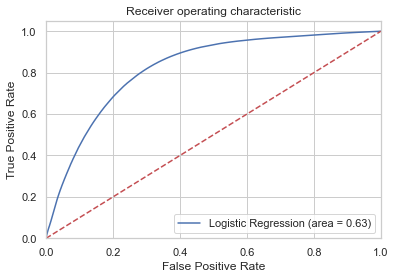

In [57]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC_hro')
plt.show()

In [45]:
tree_training.tree.sum()/len(tree_training)

0.23597096894385805

In [46]:
ge = pd.read_csv('google_earth_tree_training.csv')

In [47]:
ge.columns

Index(['Band_1', 'Band_2', 'Band_3', 'tree', 'summy', 'Band_1_Band_2',
       'Band_1_Band_3', 'Band_2_Band_1', 'Band_2_Band_3', 'Band_3_Band_1',
       'Band_3_Band_2'],
      dtype='object')

In [ ]:
tree_mask.area

In [24]:
tree_mask.area/delmar.iloc[0].geometry.area


0.2119989014551908

In [58]:
predict = logreg.predict(X)
predict.sum()/len(predict)

0.12166723032483416

In [60]:
nt = pd.read_csv('naip_training.csv')
predict = logreg.predict(nt[['Band_1','Band_2','Band_3','Band_2_Band_1']])
predict.sum()/len(predict)

0.46024777610506007

In [61]:
nt = pd.read_csv('ge_training.csv')
predict = logreg.predict(nt[['Band_1','Band_2','Band_3','Band_2_Band_1']])
predict.sum()/len(predict)

0.6262574446530775

In [50]:
nt.tree.sum()

920302

In [51]:
tree_training.to_csv('hro_training.csv')